In [2]:
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data as mnist_data
print("Tensorflow version " + tf.__version__)
tf.set_random_seed(0)

Tensorflow version 1.0.0


[Tensorflow](https://www.tensorflow.org/)
- Librería Open Source
- Para calculo numérico basada en la utilización de grafos de flujo de grafos (data flow graphs)
- Nodos representan operaciones matemáticas
- Extremos de los nodos representan arreglos multidimensionales (Tensores) que fluyen entre nodos
- Flexibilidad para resolver simbólicamente antes de realizar el calculo numérico
- CPU o GPU
- Desarrollado por ingenieros e investigadores del grupo 'Google Brain Team'

Recomendación de excelentes tutoriales [aqui](https://www.tensorflow.org/tutorials/)

# Bajo dataset

In [19]:
# Download images and labels into mnist.test (10K images+labels) and mnist.train (60K images+labels)
mnist = mnist_data.read_data_sets("data", one_hot=True, reshape=False, validation_size=0)

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz


# Defino variables y placeholders
- **Variables**: mis incognitas, lo que quiero que el sistema estime. Pesos y biases
- **Placeholders**: Features y labels

In [20]:
# input X: 28x28 grayscale images, the first dimension (None) will index the images in the mini-batch
X = tf.placeholder(tf.float32, [None, 28, 28, 1])
# correct answers will go here
Y_ = tf.placeholder(tf.float32, [None, 10])
# weights W[784, 10]   784=28*28
W = tf.Variable(tf.zeros([784, 10]))
# biases b[10]
b = tf.Variable(tf.zeros([10]))

# flatten the images into a single line of pixels
# -1 in the shape definition means "the only possible dimension that will preserve the number of elements"
XX = tf.reshape(X, [-1, 784])

In [21]:
print(mnist.train.num_examples)
print(mnist.test.num_examples)
batch_size = 100
batch_X, batch_Y = mnist.train.next_batch(batch_size)

60000
10000


In [22]:
print(batch_X.shape)
print(batch_Y.shape)

(100, 28, 28, 1)
(100, 10)


# El modelo

$l_{1,1} = x_{1,1}w_{1,1} + x_{1,2}w_{2,1} + \dots + x_{1,784}w_{784,1}$

$ l_{1,2} = x_{1,1}w_{1,2} + x_{1,2}w_{2,2} + \dots + x_{1,784}w_{784,2}$

$\vdots$

$ l_{1,10} = x_{1,1}w_{1,10} + x_{1,2}w_{2,10} + \dots + x_{1,784}w_{784,10}$

## Ejemplo

$ l_{1} = \begin{bmatrix}0.1 & 0.5 & 0.3 & 0.18 & 0.23 & 1 & 0.3 &0.5 &0.4 & 0.15\end{bmatrix}$

In [23]:
L1 = np.array([0.1, 0.5, 0.3, 0.18, 0.23, 1, 0.3, 0.5, 0.4, 0.15])

In [24]:
denominador = np.exp(L1).sum()
softmax_output = np.array([np.exp(l)/denominador for l in L1])
print(softmax_output)    
print(softmax_output.sum())

[ 0.07402306  0.11042943  0.09041197  0.08018823  0.08429956  0.18206735
  0.09041197  0.11042943  0.09992068  0.07781831]
1.0


# Escritura matricial - Vectorización

$L =
\begin{bmatrix}
    x_{1,1}       & x_{1,2} & x_{1,3} & \dots & x_{1,784} \\
    x_{2,1}       & x_{2,2} & x_{2,3} & \dots & x_{2,748} \\
  \vdots \\
    x_{100,1}       & x_{100,2} & x_{100,3} & \dots & x_{100,784}
\end{bmatrix}
\begin{bmatrix}
    w_{1,1}       & w_{1,2} & x_{1,3} & \dots & w_{1,10} \\
    w_{2,1}       & w_{2,2} & x_{2,3} & \dots & w_{2,10} \\
  \vdots \\
    w_{784,1}       & w_{748,2} & w_{748,3} & \dots & w_{748,10}
\end{bmatrix} + 
\begin{bmatrix}
b_1 & b_2 &\dots& b_{10}\\
b_1 & b_2 &\dots& b_{10}\\
\vdots \\
b_1 & b_2 &\dots& b_{10}\\
\end{bmatrix}
$

$L_{100x10} = X_{100x784}W_{784x10} + b_{100x10}$

$Y = softmax(L)$

In [25]:
# The model
Y = tf.nn.softmax(tf.matmul(XX, W) + b)

# Defino mi función de costo (loss)

In [26]:
# loss function: cross-entropy = - sum( Y_i * log(Yi) )
#                           Y: the computed output vector
#                           Y_: the desired output vector

# cross-entropy
# log takes the log of each element, * multiplies the tensors element by element
# reduce_mean will add all the components in the tensor
# so here we end up with the total cross-entropy for all images in the batch
cross_entropy = -tf.reduce_mean(Y_ * tf.log(Y)) * 1000.0  # normalized for batches of 100 images,
                                                          # *10 because  "mean" included an unwanted division by 10


In [27]:
# accuracy of the trained model, between 0 (worst) and 1 (best)
correct_prediction = tf.equal(tf.argmax(Y, 1), tf.argmax(Y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [28]:
# training, learning rate = 0.005
train_step = tf.train.GradientDescentOptimizer(0.005).minimize(cross_entropy)

In [29]:
# init
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

In [30]:
# You can call this function in a loop to train the model, 100 images at a time
def training_step(i, update_test_data, update_train_data):
    # training on batches of 100 images with 100 labels
    batch_X, batch_Y = mnist.train.next_batch(100)
    a_t=None 
    c_t=None
    a_cv=None
    c_cv=None
    # compute training values for visualisation
    if update_train_data:
        a_t, c_t = sess.run([accuracy, cross_entropy], feed_dict={X: batch_X, Y_: batch_Y})
        #print(str(i) + ": accuracy:" + str(a_t) + " loss: " + str(c_t))

    # compute test values for visualisation
    if update_test_data:
        a_cv, c_cv = sess.run([accuracy, cross_entropy], feed_dict={X: mnist.test.images, Y_: mnist.test.labels})
        #print(str(i) + ": ********* epoch " + str(i*100//mnist.train.images.shape[0]+1) + " ********* test accuracy:" + str(a_cv) + " test loss: " + str(c_cv))

    # the backpropagation training step
    sess.run(train_step, feed_dict={X: batch_X, Y_: batch_Y})
    
    return a_t, c_t, a_cv, c_cv

In [31]:
accuracy_list_train = []
accuracy_list_test = []
for i in range(1000):
    if i%2==0:
        update_test_data = True
        update_train_data = True
    else:
        update_test_data = False
        update_train_data = False
    a_t, c_t, a_cv, c_cv = training_step(i, update_test_data, update_train_data)
    if a_t is not None:
        accuracy_list_train.append(a_t)
    if a_cv is not None:
        accuracy_list_test.append(a_cv)

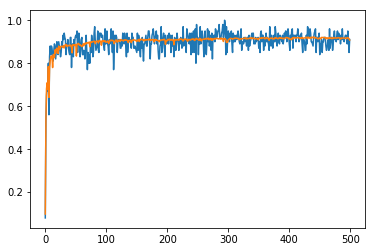

In [32]:
from matplotlib import pyplot as plt
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_test)
plt.show()

# 5 capas 
El siguiente codigo no se aplica ni se corre, es solo a manera de ejemplo

In [18]:
# five layers and their number of neurons (tha last layer has 10 softmax neurons)
L = 200
M = 100
N = 60
O = 30
# Weights initialised with small random values between -0.2 and +0.2
# When using RELUs, make sure biases are initialised with small *positive* values for example 0.1 = tf.ones([K])/10
W1 = tf.Variable(tf.truncated_normal([784, L], stddev=0.1))  # 784 = 28 * 28
B1 = tf.Variable(tf.zeros([L]))
W2 = tf.Variable(tf.truncated_normal([L, M], stddev=0.1))
B2 = tf.Variable(tf.zeros([M]))
W3 = tf.Variable(tf.truncated_normal([M, N], stddev=0.1))
B3 = tf.Variable(tf.zeros([N]))
W4 = tf.Variable(tf.truncated_normal([N, O], stddev=0.1))
B4 = tf.Variable(tf.zeros([O]))
W5 = tf.Variable(tf.truncated_normal([O, 10], stddev=0.1))
B5 = tf.Variable(tf.zeros([10]))

# The model
XX = tf.reshape(X, [-1, 784])
Y1 = tf.nn.sigmoid(tf.matmul(XX, W1) + B1)
Y2 = tf.nn.sigmoid(tf.matmul(Y1, W2) + B2)
Y3 = tf.nn.sigmoid(tf.matmul(Y2, W3) + B3)
Y4 = tf.nn.sigmoid(tf.matmul(Y3, W4) + B4)
Ylogits = tf.matmul(Y4, W5) + B5
Y = tf.nn.softmax(Ylogits)